In [ ]:
#!pip install --upgrade pip setuptools wheel
#!pip install pymc==5.15.0 arviz==0.15.1 pytensor==2.17.6 numpy==1.26.4 matplotlib seaborn pandas scikit-learn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid", context="notebook", font_scale=1.1)


In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/dairy-cattle-dataset-1/dairy_cattle_dataset.csv")

print("Data loaded successfully!")
print(df.head())

Data loaded successfully!
   CowID  Parity  DaysInMilk  BCS  Temp_C  MaizeBran_kg  Cottonseed_kg  \
0  C0001       3         145  3.7    22.8          4.53           1.73   
1  C0002       4         201  3.5    25.5          2.63           1.74   
2  C0003       1         212  3.5    31.4          3.90           1.38   
3  C0004       3         220  2.9    28.7          4.87           1.03   
4  C0005       3         240  2.7    28.8          3.08           1.70   

   BrewersGrain_kg  GrassSilage_kg  NEL_MJkg  CP_pct  Lysine_pct  MilkYield_L  \
0             1.27            3.60      5.99    13.6        0.60         17.3   
1             1.48            4.30      6.19    14.4        0.64         14.5   
2             3.88            2.67      5.83    14.3        0.62         19.6   
3             2.61            1.29      6.01    13.4        0.67         15.6   
4             1.04            2.09      5.84    13.1        0.61         12.3   

   MilkFat_pct  MilkProt_pct  FCE_LperkgDM

In [ ]:
# Extracting relevant fields
xvals = df['DaysInMilk'].values
yvals = df['MilkYield_L'].values
groups = df['CowID'].astype('category').cat.codes

print(f"xvals (DaysInMilk): {xvals.shape}")
print(f"yvals (MilkYield_L): {yvals.shape}")
print(f"groups (Cows): {len(np.unique(groups))} unique cows")


xvals (DaysInMilk): (1000,)
yvals (MilkYield_L): (1000,)
groups (Cows): 1000 unique cows


In [ ]:
with pm.Model() as model:
    # Hyperpriors for group intercepts
    mu_a = pm.Normal('mu_a', mu=0, sigma=10)
    sigma_a = pm.HalfNormal('sigma_a', sigma=5)
    
    # Individual cow-level intercepts (hierarchical)
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=len(np.unique(groups)))
    
    # Common slope for DaysInMilk
    b = pm.Normal('b', mu=0, sigma=1)
    
    # Model error
    sigma_y = pm.HalfNormal('sigma_y', sigma=5)
    
    # Linear model
    mu = a[groups] + b * xvals
    
    # Likelihood (observed data)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_y, observed=yvals)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

print("Model trained successfully!")


Output()

Model trained successfully!


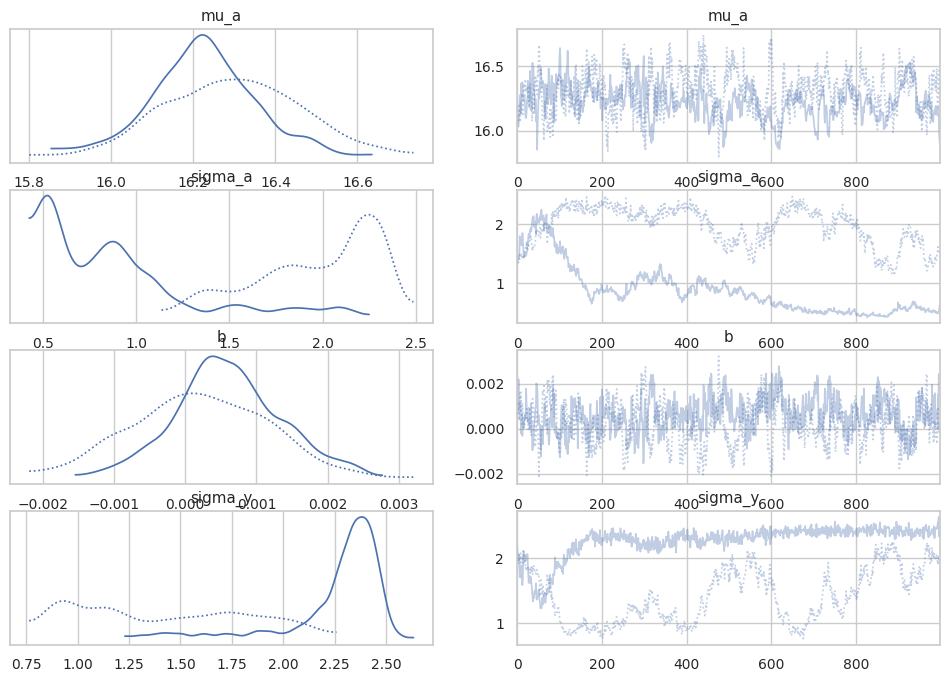

In [ ]:
az.summary(trace, var_names=["mu_a", "sigma_a", "b", "sigma_y"])
az.plot_trace(trace, var_names=["mu_a", "sigma_a", "b", "sigma_y"])
plt.show()


Output()

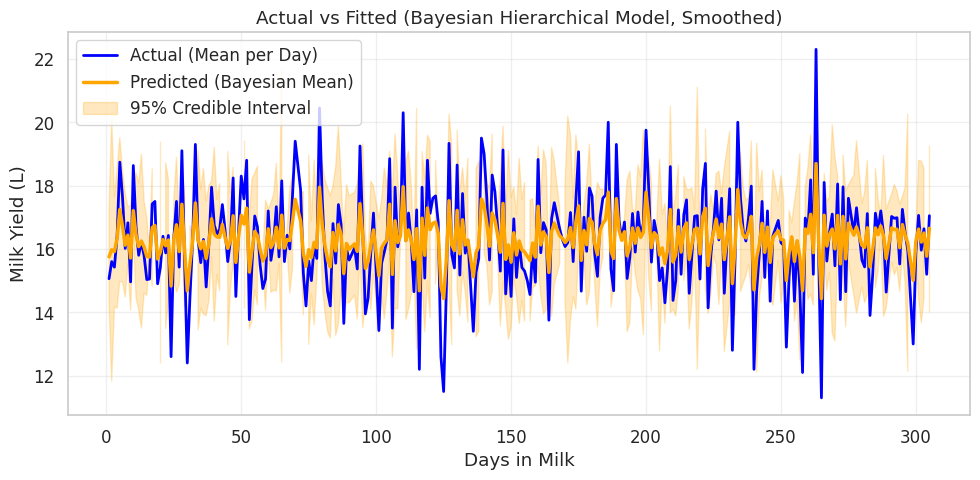

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Posterior predictive sampling
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=42)

# Gettin predicted mean per observation
y_pred = posterior_predictive.posterior_predictive['y_obs'].mean(dim=["chain", "draw"]).values

# Group predictions by day and computin smooth meaan & the credible interval
df_pred = pd.DataFrame({
    'DaysInMilk': xvals,
    'Actual': yvals,
    'Predicted': y_pred
}).groupby('DaysInMilk').agg(['mean', 'std'])

pred_mean = df_pred['Predicted', 'mean']
pred_std = df_pred['Predicted', 'std']
actual_mean = df_pred['Actual', 'mean']

#plot 
plt.figure(figsize=(10, 5))
plt.plot(df_pred.index, actual_mean, color='blue', label='Actual (Mean per Day)', linewidth=2)
plt.plot(df_pred.index, pred_mean, color='orange', label='Predicted (Bayesian Mean)', linewidth=2.5)
plt.fill_between(df_pred.index,
                 pred_mean - 1.96 * pred_std,
                 pred_mean + 1.96 * pred_std,
                 color='orange', alpha=0.25, label='95% Credible Interval')

plt.xlabel("Days in Milk")
plt.ylabel("Milk Yield (L)")
plt.title("Actual vs Fitted (Bayesian Hierarchical Model, Smoothed)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


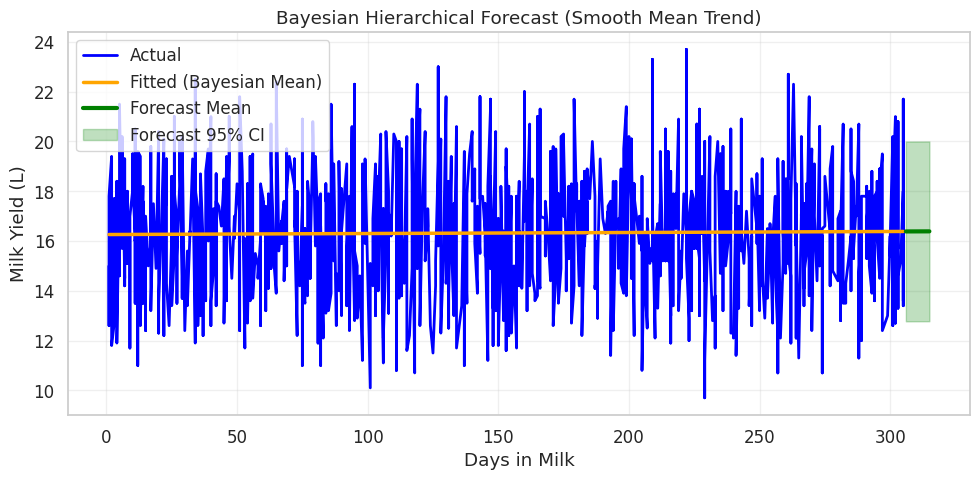

In [ ]:
# Forecasting with posterior means instead of full draws
forecast_steps = 10

# Sortig xvals and corresponding yvals for cleaner forecast continuation
sort_idx = np.argsort(xvals)
xvals_sorted = xvals[sort_idx]
yvals_sorted = yvals[sort_idx]

# Generating the next time steps after the last known observation
future_days = np.arange(xvals_sorted[-1] + 1, xvals_sorted[-1] + forecast_steps + 1)

# Computig posterior means for slope/intercepts
a_means = trace.posterior["a"].mean(dim=("chain", "draw")).values
b_mean = trace.posterior["b"].mean(dim=("chain", "draw")).values
sigma_y_mean = trace.posterior["sigma_y"].mean(dim=("chain", "draw")).values

# taking the mean intercept (global trend)
a_global = a_means.mean()

# Predictig future milk yield (hierarchical mean trend)
future_mean = a_global + b_mean * future_days
future_std = sigma_y_mean

# Plot for forecast continuation
plt.figure(figsize=(10, 5))
plt.plot(xvals_sorted, yvals_sorted, color='blue', linewidth=2, label='Actual')
plt.plot(xvals_sorted, a_global + b_mean * xvals_sorted, color='orange', linewidth=2.5, label='Fitted (Bayesian Mean)')
plt.plot(future_days, future_mean, color='green', linewidth=3, label='Forecast Mean')
plt.fill_between(future_days,
                 future_mean - 1.96 * future_std,
                 future_mean + 1.96 * future_std,
                 color='green', alpha=0.25, label='Forecast 95% CI')

plt.xlabel("Days in Milk")
plt.ylabel("Milk Yield (L)")
plt.title("Bayesian Hierarchical Forecast (Smooth Mean Trend)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
r2 = r2_score(yvals, y_pred)
mae = mean_absolute_error(yvals, y_pred)
rmse = mean_squared_error(yvals, y_pred, squared=False)

print("Model Performance Metrics:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


Model Performance Metrics:
R²: 0.637
MAE: 1.198
RMSE: 1.489


In [ ]:
# imports & feature setup for ML & MILP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import joblib
sns.set(style="whitegrid", context="notebook", font_scale=1.05)

# feature matrix using feed/nutrition variables
feature_cols = [
    "MaizeBran_kg", "Cottonseed_kg", "BrewersGrain_kg", "GrassSilage_kg",
    "NEL_MJkg", "CP_pct", "Lysine_pct"
]

# alikkle Safety check for missing requirements
missing = [c for c in feature_cols + ["MilkYield_L"] if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns in df: {missing}")

X = df[feature_cols].copy()
y = df["MilkYield_L"].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Feature matrix shape: {X.shape}, Training: {X_train.shape}, Test: {X_test.shape}")


Feature matrix shape: (1000, 7), Training: (800, 7), Test: (200, 7)


Gradient Boosting performance (test set):
  MAE  = 0.8375 L
  RMSE = 1.0443 L
  R²   = 0.8286


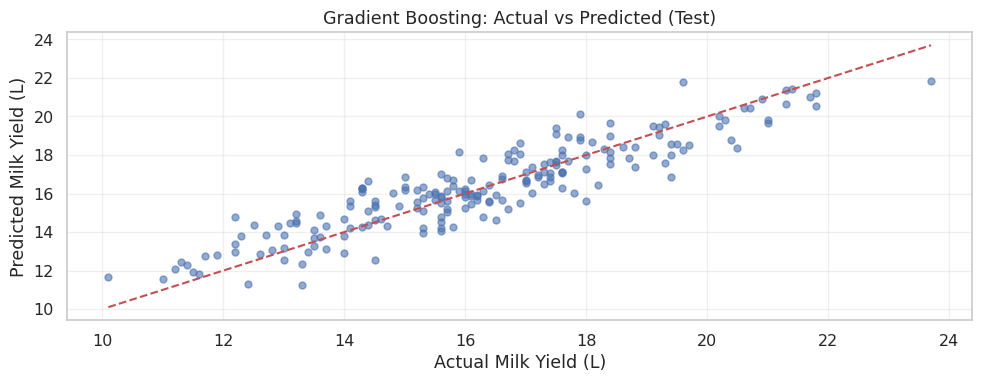

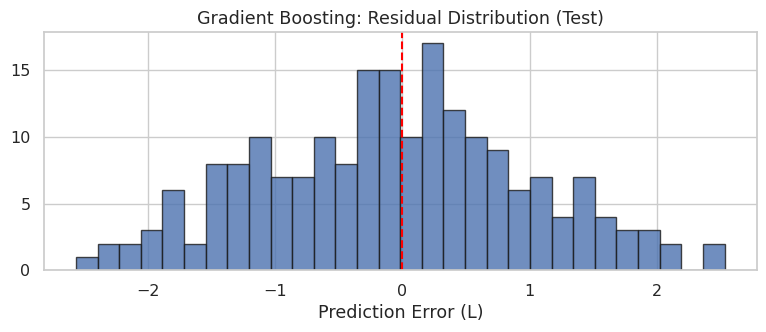

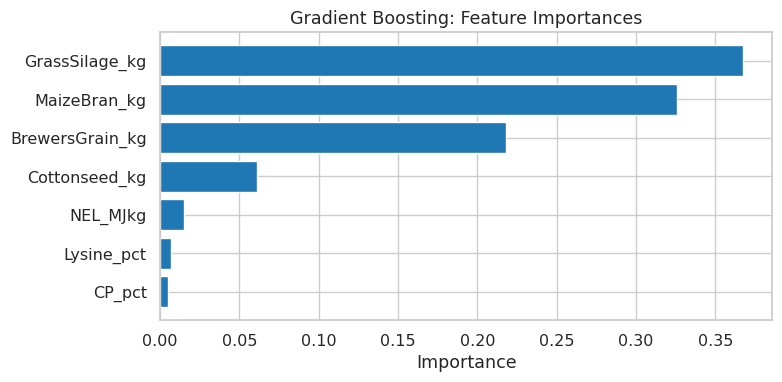

In [ ]:
# Trainin Gradient Boosting, evaluate metrics, and plots
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb.fit(X_train, y_train)

# Save model for reuse
joblib.dump(gb, "gb_model.joblib")

# Predictions & metrics
y_pred_test = gb.predict(X_test)
y_pred_train = gb.predict(X_train)

gb_mae = mean_absolute_error(y_test, y_pred_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
gb_r2 = r2_score(y_test, y_pred_test)

print("Gradient Boosting performance (test set):")
print(f"  MAE  = {gb_mae:.4f} L")
print(f"  RMSE = {gb_rmse:.4f} L")
print(f"  R²   = {gb_r2:.4f}")

# Plot 1: Actual vs Predicted (test)
plt.figure(figsize=(10,4))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=25)
mn = min(y_test.min(), y_pred_test.min())
mx = max(y_test.max(), y_pred_test.max())
plt.plot([mn,mx], [mn,mx], 'r--', lw=1.5)
plt.xlabel("Actual Milk Yield (L)")
plt.ylabel("Predicted Milk Yield (L)")
plt.title("Gradient Boosting: Actual vs Predicted (Test)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Residual distribution
residuals = y_test - y_pred_test
plt.figure(figsize=(8,3.5))
plt.hist(residuals, bins=30, alpha=0.8, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error (L)")
plt.title("Gradient Boosting: Residual Distribution (Test)")
plt.tight_layout()
plt.show()

# Plot 3: Feature importance
importances = gb.feature_importances_
feat_imp = pd.DataFrame({"feature": feature_cols, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=True)

plt.figure(figsize=(8,4))
plt.barh(feat_imp["feature"], feat_imp["importance"], color='tab:blue')
plt.xlabel("Importance")
plt.title("Gradient Boosting: Feature Importances")
plt.tight_layout()
plt.show()


                    Model      MAE     RMSE       R2
         GradientBoosting 0.837520 1.044268 0.828613
Bayesian (posterior mean) 1.205491 1.516862 0.638386


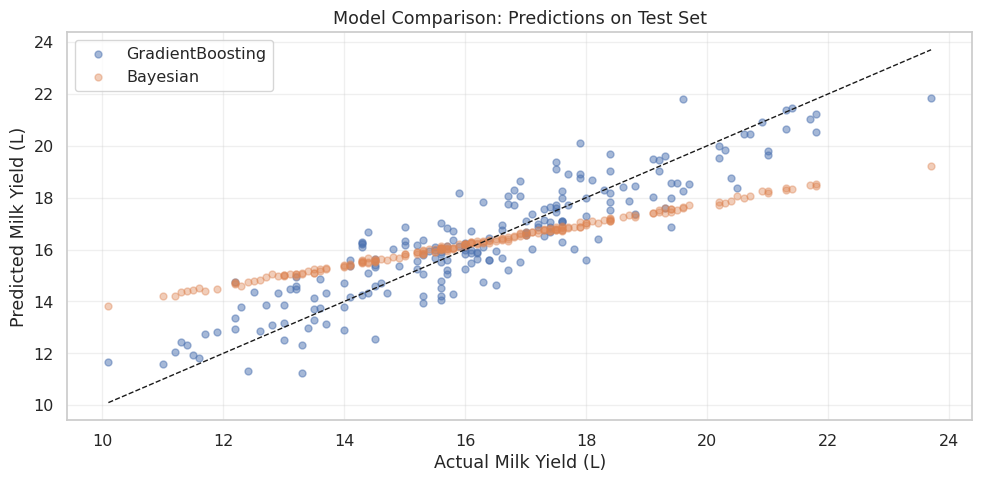

In [ ]:
# Create comparison table for models (Bayesian fitted mean vs GB)
# Bayesian fitted mean: use the posterior predictive mean that you computed earlier as `y_fitted` or recompute if needed.
# If `y_fitted` exists in the namespace (from your posterior predictive), align it to df index; otherwise compute group means.

# Try to get Bayesian fitted mean per observation
if "y_fitted" in globals():
    bayes_fitted_obs = y_fitted  # assumes aligned with original ordering
else:
    # Fallback: compute posterior predictive mean if posterior_predictive exists
    if "posterior_predictive" in globals():
        try:
            bayes_fitted_obs = posterior_predictive.posterior_predictive['y_obs'].mean(dim=("chain","draw")).values
        except Exception:
            bayes_fitted_obs = None
    else:
        bayes_fitted_obs = None

# Align predictions to the test set for a fair comparison
# Build DataFrame mapping indices -> predictions
df_all = X.copy()
df_all["actual"] = y.values
df_all["gb_pred"] = gb.predict(X)

if bayes_fitted_obs is not None and len(bayes_fitted_obs) == len(df_all):
    df_all["bayes_pred"] = bayes_fitted_obs
else:
    df_all["bayes_pred"] = np.nan

# Compute metrics for both models on the same test split indices
test_idx = X_test.index

metrics = []
# Gradient Boosting metrics
metrics.append({
    "Model": "GradientBoosting",
    "MAE": mean_absolute_error(y_test, y_pred_test),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
    "R2": r2_score(y_test, y_pred_test)
})

# Bayesian metrics 
if not df_all.loc[test_idx, "bayes_pred"].isna().all():
    yb_test = df_all.loc[test_idx, "bayes_pred"].values
    metrics.append({
        "Model": "Bayesian (posterior mean)",
        "MAE": mean_absolute_error(y_test, yb_test),
        "RMSE": np.sqrt(mean_squared_error(y_test, yb_test)),
        "R2": r2_score(y_test, yb_test)
    })

metrics_df = pd.DataFrame(metrics).sort_values("R2", ascending=False).reset_index(drop=True)
print(metrics_df.to_string(index=False))

# Scatter plot overlay
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, label="GradientBoosting", s=25)
if not df_all.loc[test_idx, "bayes_pred"].isna().all():
    plt.scatter(y_test, df_all.loc[test_idx, "bayes_pred"], alpha=0.4, label="Bayesian", s=25)
plt.plot([mn,mx], [mn,mx], 'k--', lw=1)
plt.xlabel("Actual Milk Yield (L)")
plt.ylabel("Predicted Milk Yield (L)")
plt.title("Model Comparison: Predictions on Test Set")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import linprog

def optimize_feed_ration_corrected():
    
    #  FEED PRICES (UGX per kg)
    prices = {
        'maize_bran': 570,      
        'cottonseed': 3000,      
        'brewers_grain': 528,   
        'grass_silage': 550     
    }
    
    # NUTRITIONAL REQUIREMENTS
    # For 275kg cow
    maintenance_req = {
        'ME': 7.0,      # Mcal/day
        'CP': 191.0,    # g/day
        'Ca': 10.0,     # g/day
        'P': 7.0        # g/day
    }
    
    # Production requirements per liter of milk
    production_req_per_liter = {
        'ME': 0.62,     # Mcal/L
        'CP': 45.0,     # g/L
        'Ca': 1.605,    # g/L
        'P': 0.99       # g/L
    }
    
    # FEED NUTRITIONAL COMPOSITION
    feed_composition = {
        'maize_bran': {
            'ME': 2.8,      # Mcal/kg
            'CP': 90.0,     # g/kg
            'Ca': 0.5,      # g/kg
            'P': 3.0,       # g/kg
            'min': 1.0, 'max': 6.0
        },
        'cottonseed': {
            'ME': 3.2,      # Mcal/kg
            'CP': 230.0,    # g/kg
            'Ca': 2.0,      # g/kg
            'P': 11.0,      # g/kg
            'min': 0.5, 'max': 3.0
        },
        'brewers_grain': {
            'ME': 2.6,      # Mcal/kg
            'CP': 250.0,    # g/kg
            'Ca': 1.5,      # g/kg
            'P': 5.0,       # g/kg
            'min': 0.5, 'max': 4.0
        },
        'grass_silage': {
            'ME': 2.2,      # Mcal/kg
            'CP': 80.0,     # g/kg
            'Ca': 5.0,      # g/kg
            'P': 3.0,       # g/kg
            'min': 2.0, 'max': 8.0
        }
    }
    
    # CONSTRAINT SETUP
    
    # Variables: [maize_bran, cottonseed, brewers_grain, grass_silage, milk_yield]
    c = np.array([570, 3000, 528, 550, 0])  # Minimize cost
    
    A_ub = []  # Inequality constraints (<=)
    b_ub = []
    
    print(" NUTRIENT CALCULATIONS FOR EACH FEED:")
    print("=" * 50)
    
    # To display nutrient content per kg of each feed
    feeds = ['maize_bran', 'cottonseed', 'brewers_grain', 'grass_silage']
    nutrients = ['ME', 'CP', 'Ca', 'P']
    
    for feed in feeds:
        print(f"\n{feed.upper():<15} per kg:")
        for nutrient in nutrients:
            value = feed_composition[feed][nutrient]
            unit = "Mcal" if nutrient == 'ME' else "g"
            print(f"  {nutrient}: {value} {unit}")
    
    # 1. ME CONSTRAINT: sum(feed_ME) >= maintenance_ME + milk_ME
    # Convert to: -sum(feed_ME) + milk_ME <= -maintenance_ME
    A_ub.append([
        -feed_composition['maize_bran']['ME'],      # -2.8
        -feed_composition['cottonseed']['ME'],      # -3.2  
        -feed_composition['brewers_grain']['ME'],   # -2.6
        -feed_composition['grass_silage']['ME'],    # -2.2
        production_req_per_liter['ME']              # +0.62
    ])
    b_ub.append(-maintenance_req['ME'])  # -7.0
    print(f"\nME Constraint: Feed ME >= {maintenance_req['ME']} + {production_req_per_liter['ME']}*Milk")
    
    # 2. CP CONSTRAINT: sum(feed_CP) >= maintenance_CP + milk_CP
    A_ub.append([
        -feed_composition['maize_bran']['CP'],      # -90
        -feed_composition['cottonseed']['CP'],      # -230
        -feed_composition['brewers_grain']['CP'],   # -250
        -feed_composition['grass_silage']['CP'],    # -80
        production_req_per_liter['CP']              # +45
    ])
    b_ub.append(-maintenance_req['CP'])  # -191
    print(f"CP Constraint: Feed CP >= {maintenance_req['CP']} + {production_req_per_liter['CP']}*Milk")
    
    # 3. CALCIUM CONSTRAINT
    A_ub.append([
        -feed_composition['maize_bran']['Ca'],      # -0.5
        -feed_composition['cottonseed']['Ca'],      # -2.0
        -feed_composition['brewers_grain']['Ca'],   # -1.5
        -feed_composition['grass_silage']['Ca'],    # -5.0
        production_req_per_liter['Ca']              # +1.605
    ])
    b_ub.append(-maintenance_req['Ca'])  # -10
    print(f"Ca Constraint: Feed Ca >= {maintenance_req['Ca']} + {production_req_per_liter['Ca']}*Milk")
    
    # 4. PHOSPHORUS CONSTRAINT
    A_ub.append([
        -feed_composition['maize_bran']['P'],       # -3.0
        -feed_composition['cottonseed']['P'],       # -11.0
        -feed_composition['brewers_grain']['P'],    # -5.0
        -feed_composition['grass_silage']['P'],     # -3.0
        production_req_per_liter['P']               # +0.99
    ])
    b_ub.append(-maintenance_req['P'])  # -7
    print(f"P Constraint:  Feed P >= {maintenance_req['P']} + {production_req_per_liter['P']}*Milk")
    
    # 5. FEED MINIMUM CONSTRAINTS (each feed >= minimum)
    A_ub.append([-1, 0, 0, 0, 0])  # Maize bran >= 1kg → -maize <= -1
    b_ub.append(-1)
    A_ub.append([0, -1, 0, 0, 0])  # Cottonseed >= 0.5kg
    b_ub.append(-0.5)
    A_ub.append([0, 0, -1, 0, 0])  # Brewers grain >= 0.5kg
    b_ub.append(-0.5)
    A_ub.append([0, 0, 0, -1, 0])  # Grass silage >= 2kg
    b_ub.append(-2)
    
    # 6. FEED MAXIMUM CONSTRAINTS
    A_ub.append([1, 0, 0, 0, 0])   # Maize bran <= 6kg
    b_ub.append(6)
    A_ub.append([0, 1, 0, 0, 0])   # Cottonseed <= 3kg
    b_ub.append(3)
    A_ub.append([0, 0, 1, 0, 0])   # Brewers grain <= 4kg
    b_ub.append(4)
    A_ub.append([0, 0, 0, 1, 0])   # Grass silage <= 8kg
    b_ub.append(8)
    
    # 7. TOTAL DMI CONSTRAINT
    A_ub.append([1, 1, 1, 1, 0])   # Total feed <= 8.25kg
    b_ub.append(8.25)
    
    # 8. MILK YIELD CONSTRAINTS
    A_ub.append([0, 0, 0, 0, 1])   # Milk <= 25L
    b_ub.append(25)
    A_ub.append([0, 0, 0, 0, -1])  # Milk >= 10L → -milk <= -10
    b_ub.append(-10)
    
    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)
    
    # SOLVE 
    print(f"\n SOLVING OPTIMIZATION...")
    print(f"Number of constraints: {len(A_ub)}")
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, 
                    bounds=[(1, 6), (0.5, 3), (0.5, 4), (2, 8), (10, 25)], 
                    method='highs')
    
    if result.success:
        display_detailed_nutrient_analysis(result.x, feed_composition, prices, maintenance_req, production_req_per_liter)
    else:
        print(f" Optimization failed: {result.message}")

def display_detailed_nutrient_analysis(x, feed_comp, prices, maintenance_req, production_req):
    """Show EXACT nutrient calculations"""
    
    maize_kg, cotton_kg, brewers_kg, silage_kg, milk_yield = x
    
    print("\n" + "="*70)
    print(" OPTIMAL SOLUTION WITH DETAILED NUTRIENT ANALYSIS")
    print("="*70)
    
    # Feed amounts and costs
    feeds = [
        ('Maize Bran', maize_kg, prices['maize_bran']),
        ('Cottonseed', cotton_kg, prices['cottonseed']),
        ('Brewers Grain', brewers_kg, prices['brewers_grain']),
        ('Grass Silage', silage_kg, prices['grass_silage'])
    ]
    
    print(f"\n OPTIMAL FEED RATION (Milk Target: {milk_yield:.1f} L):")
    for name, kg, price in feeds:
        print(f"   {name:<15} {kg:>5.2f} kg = UGX {kg * price:>6.0f}")
    
    total_cost = sum(kg * price for _, kg, price in feeds)
    print(f"   {'Total Feed Cost':<15} {'':>5} = UGX {total_cost:>6.0f}")
    print(f"   {'Cost per Liter':<15} {'':>5} = UGX {total_cost/milk_yield:>6.0f}")
    
    # DETAILED NUTRIENT BREAKDOWN
    print(f"\n DETAILED NUTRIENT CALCULATIONS:")
    print("-" * 70)
    
    nutrients = ['ME', 'CP', 'Ca', 'P']
    total_required = {n: maintenance_req[n] + milk_yield * production_req[n] for n in nutrients}
    
    for nutrient in nutrients:
        print(f"\n{nutrient}:")
        print(f"  Required: {total_required[nutrient]:.1f} {'Mcal' if nutrient == 'ME' else 'g'}")
        print(f"  Breakdown from feeds:")
        
        total_from_feeds = 0
        for feed_name, feed_kg, feed_key in [('Maize Bran', maize_kg, 'maize_bran'),
                                           ('Cottonseed', cotton_kg, 'cottonseed'),
                                           ('Brewers Grain', brewers_kg, 'brewers_grain'),
                                           ('Grass Silage', silage_kg, 'grass_silage')]:
            nutrient_per_kg = feed_comp[feed_key][nutrient]
            nutrient_from_feed = feed_kg * nutrient_per_kg
            total_from_feeds += nutrient_from_feed
            
            if feed_kg > 0.01:  # Only show if significant amount
                unit = "Mcal" if nutrient == 'ME' else "g"
                print(f"    {feed_name:<15} {feed_kg:>4.2f}kg × {nutrient_per_kg:>4.1f}{unit}/kg = {nutrient_from_feed:>5.1f}{unit}")
        
        balance = total_from_feeds - total_required[nutrient]
        status = " MET" if balance >= -0.1 else " DEFICIT"  # Small tolerance
        print(f"  Total from feeds: {total_from_feeds:.1f} {'Mcal' if nutrient == 'ME' else 'g'}")
        print(f"  Balance: {balance:+.1f} {'Mcal' if nutrient == 'ME' else 'g'} {status}")

# calls & Runs it
optimize_feed_ration_corrected()

 NUTRIENT CALCULATIONS FOR EACH FEED:

MAIZE_BRAN      per kg:
  ME: 2.8 Mcal
  CP: 90.0 g
  Ca: 0.5 g
  P: 3.0 g

COTTONSEED      per kg:
  ME: 3.2 Mcal
  CP: 230.0 g
  Ca: 2.0 g
  P: 11.0 g

BREWERS_GRAIN   per kg:
  ME: 2.6 Mcal
  CP: 250.0 g
  Ca: 1.5 g
  P: 5.0 g

GRASS_SILAGE    per kg:
  ME: 2.2 Mcal
  CP: 80.0 g
  Ca: 5.0 g
  P: 3.0 g

ME Constraint: Feed ME >= 7.0 + 0.62*Milk
CP Constraint: Feed CP >= 191.0 + 45.0*Milk
Ca Constraint: Feed Ca >= 10.0 + 1.605*Milk
P Constraint:  Feed P >= 7.0 + 0.99*Milk

 SOLVING OPTIMIZATION...
Number of constraints: 15

 OPTIMAL SOLUTION WITH DETAILED NUTRIENT ANALYSIS

 OPTIMAL FEED RATION (Milk Target: 10.0 L):
   Maize Bran       1.00 kg = UGX    570
   Cottonseed       0.50 kg = UGX   1500
   Brewers Grain    0.50 kg = UGX    264
   Grass Silage     4.76 kg = UGX   2618
   Total Feed Cost       = UGX   4952
   Cost per Liter        = UGX    495

 DETAILED NUTRIENT CALCULATIONS:
-------------------------------------------------------------